In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.cluster import AgglomerativeClustering

In [6]:
sparql = SPARQLWrapper("http://Vins-Macbook.local:7200/repositories/PCA_Ontology")

# Define the SPARQL query to extract ESG observations.
sparql.setQuery("""

PREFIX ex: <http://example.org/esg#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
 
SELECT DISTINCT ?company ?year ?metric ?value ?category ?pillar ?industry ?model ?unit
WHERE {
  ?obs a ex:ESGObservation ;
       ex:hasCompany ?company ;
       ex:hasYear ?year ;
       ex:hasMetric ?metric ;
       ex:hasValue ?value ;
       ex:hasUnit ?unit ;
       ex:hasCategory ?category ;
       ex:hasPillar ?pillar .
  ?metric ex:belongsToIndustry ?industry .
  ?model ex:relatedToMetric ?metric .
 
  FILTER regex(str(?industry), "semiconductors", "i")
}
ORDER BY ?company ?metric ?year

""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [7]:
# Convert SPARQL results to a flat list of records
records = []
for result in results["results"]["bindings"]:
    company = result["company"]["value"].split("#")[-1] if "#" in result["company"]["value"] else result["company"]["value"]
    year = result["year"]["value"]
    metric = result["metric"]["value"].split("#")[-1] if "#" in result["metric"]["value"] else result["metric"]["value"]
    value = float(result["value"]["value"])
    category = result["category"]["value"].split("#")[-1] if "#" in result["category"]["value"] else result["category"]["value"]
    pillar = result["pillar"]["value"].split("#")[-1] if "#" in result["pillar"]["value"] else result["pillar"]["value"]
    industry = result["industry"]["value"].split("#")[-1] if "#" in result["industry"]["value"] else result["industry"]["value"]
    model = result["model"]["value"].split("#")[-1] if "#" in result["model"]["value"] else result["model"]["value"]
    unit = result["unit"]["value"]  # Keeping unit as-is since it's usually a string like "tons CO2e"

    records.append({
        "company": company,
        "year": year,
        "metric": metric,
        "value": value,
        "category": category,
        "pillar": pillar,
        "industry": industry,
        "model": model,
        "unit": unit
    })


In [4]:
dp = pd.read_csv("/Users/vinantipathare/Desktop/Docs/CS Project/capstone-project-2025-t1-25t1-9900-t12a-chocolate/Normalized_Data/semiconductors_sasb_final.csv")

In [5]:
bp = pd.read_csv("/Users/vinantipathare/Desktop/Docs/CS Project/capstone-project-2025-t1-25t1-9900-t12a-chocolate/Normalized_Data/biopharma_sasb_final.csv")

In [8]:

# Create DataFrame from records
df_raw_sc = pd.DataFrame(records)

# Create a unique identifier for each entity (company_year)
df_raw_sc["entity"] = df_raw_sc["company"] + "_" + df_raw_sc["year"]

# Pivot: rows = entity, columns = metric, values = value
df_pivot = df_raw_sc.pivot_table(index="entity", columns="metric", values="value")
# Replace 0 values with NaN (assuming zeros indicate missing/unreported values)
df_pivot = df_pivot.replace(0, np.nan)

# # Drop columns with more than 90% missing values
# threshold = 0.8
# cols_to_keep = [col for col in df_pivot.columns if df_pivot[col].isnull().mean() <= threshold]
# df_pivot_filtered = df_pivot[cols_to_keep]

# Compute the median for each metric (column), ignoring NaN
median_values = df_pivot.median()

Explained Variance Ratio per PC: [0.1786155  0.1411782  0.12961067 0.12688867]
Cumulative Explained Variance: [0.1786155  0.3197937  0.44940436 0.57629303]


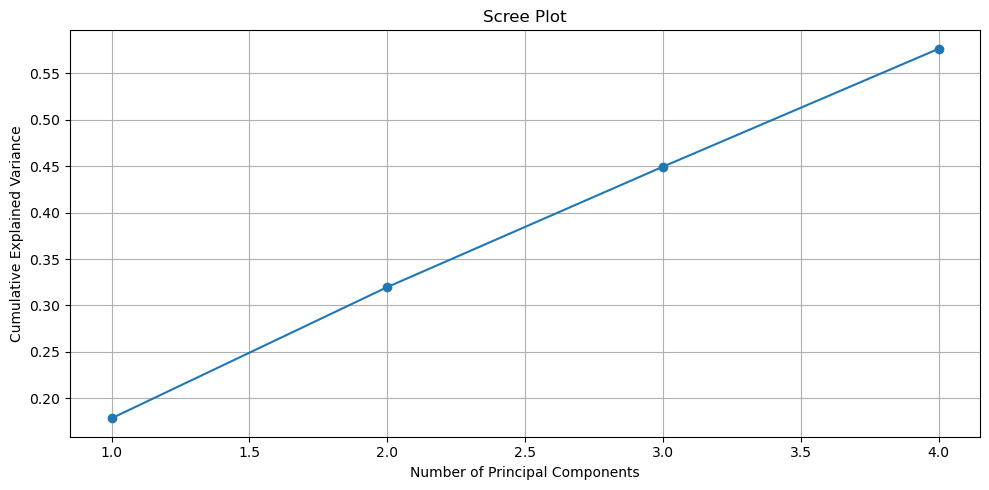

In [16]:
# Impute the missing values with the corresponding column medians
df_pivot_imputed = df_pivot.fillna(median_values)
# Standardization is important for PCA to give each feature equal weight.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pivot_imputed)

# Perform PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio per PC:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance)) # will tell us how much information each PC is capturing 

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

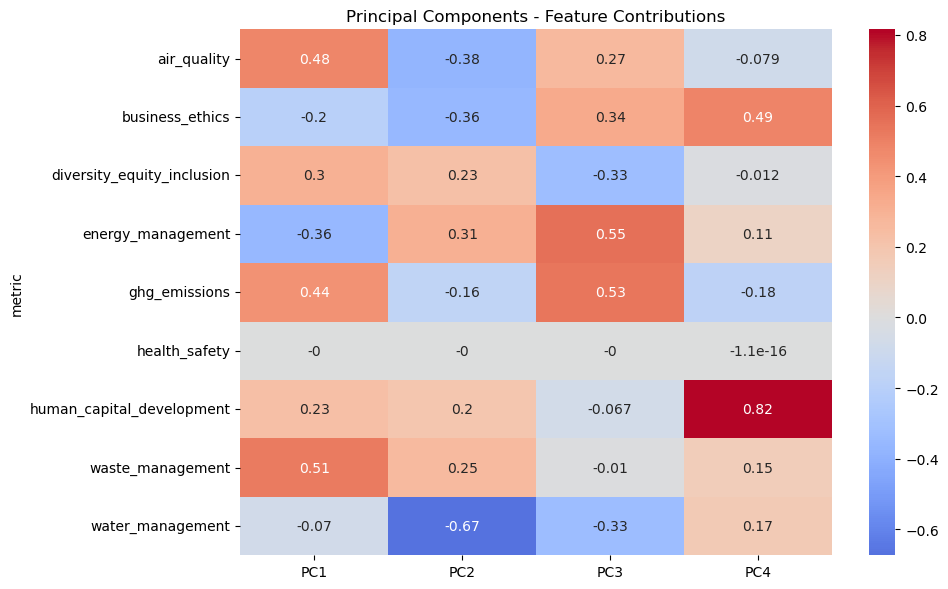

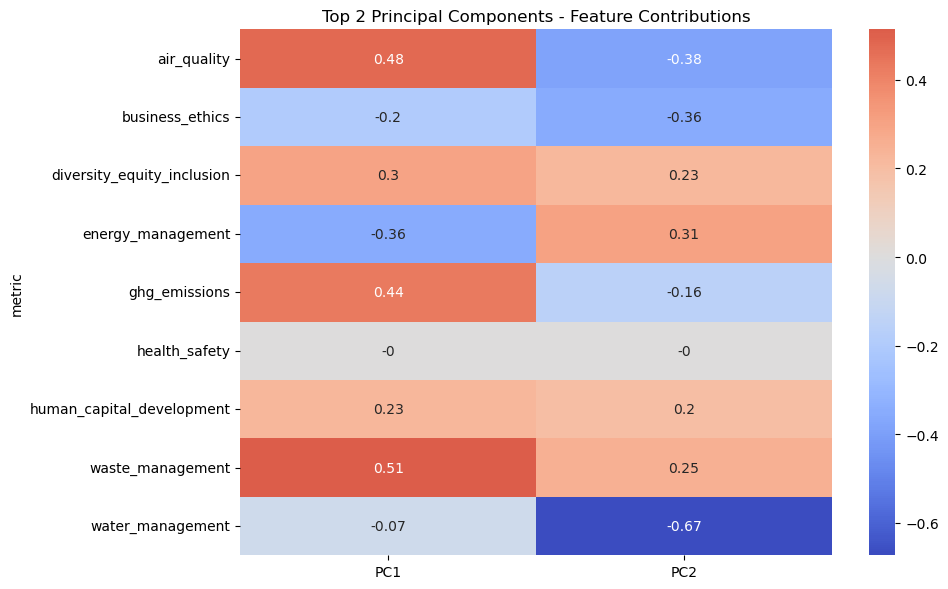

In [17]:

# Loadings indicate how much each original ESG metric contributes to each PC.
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pivot_imputed.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
# Plot a heatmap for the PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :4], annot=True, cmap="coolwarm", center=0)
plt.title("Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()
# Plot a heatmap for the top 2 PCs for clearer visualization.
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap="coolwarm", center=0)
plt.title("Top 2 Principal Components - Feature Contributions")
plt.tight_layout()
plt.show()

In [18]:

# These scores are the representation of each observation in the PC space.
pca_scores = pd.DataFrame(
    pca_result,
    columns=[f"PC{i+1}" for i in range(pca_result.shape[1])]
)
pca_scores["entity"] = df_pivot_imputed.index
# Merge loadings with the pillar information

# First, create a dataframe of unique metric→pillar mappings from df_raw.
df_metric_pillar = df_raw_sc[['metric', 'pillar']].drop_duplicates()

# loadings index is the metric name, so we reset that index to merge.
loadings_with_pillar = (
    loadings
    .reset_index()                        # "index" is the metric name
    .rename(columns={'index': 'metric'})  
    .merge(df_metric_pillar, on='metric', how='left')
)

# Look at the top metrics (by absolute loading) for a given PC

# top metrics for PC1 (largest absolute value of loading)
pc1_sorted = loadings_with_pillar[['metric', 'pillar', 'PC1']] \
    .assign(loading_abs=loadings_with_pillar['PC1'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC1:")
print(pc1_sorted.head(10))

# top metrics for PC2
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC2']] \
    .assign(loading_abs=loadings_with_pillar['PC2'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC2:")
print(pc2_sorted.head(10))

# top metrics for PC3
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC3']] \
    .assign(loading_abs=loadings_with_pillar['PC3'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC3:")
print(pc2_sorted.head(10))

# top metrics for PC4
pc2_sorted = loadings_with_pillar[['metric', 'pillar', 'PC4']] \
    .assign(loading_abs=loadings_with_pillar['PC4'].abs()) \
    .sort_values('loading_abs', ascending=False)

print("Top metrics driving PC4:")
print(pc2_sorted.head(10))



Top metrics driving PC1:
                        metric         pillar       PC1  loading_abs
11            waste_management         e_risk  0.514186     0.514186
12            waste_management  e_opportunity  0.514186     0.514186
0                  air_quality  g_opportunity  0.480429     0.480429
1                  air_quality         e_risk  0.480429     0.480429
7                ghg_emissions         e_risk  0.435068     0.435068
8                ghg_emissions  e_opportunity  0.435068     0.435068
6            energy_management  e_opportunity -0.356915     0.356915
4   diversity_equity_inclusion  s_opportunity  0.303508     0.303508
5   diversity_equity_inclusion         s_risk  0.303508     0.303508
10   human_capital_development         s_risk  0.228474     0.228474
Top metrics driving PC2:
                        metric         pillar       PC2  loading_abs
13            water_management         e_risk -0.673262     0.673262
14            water_management  e_opportunity -0.6732

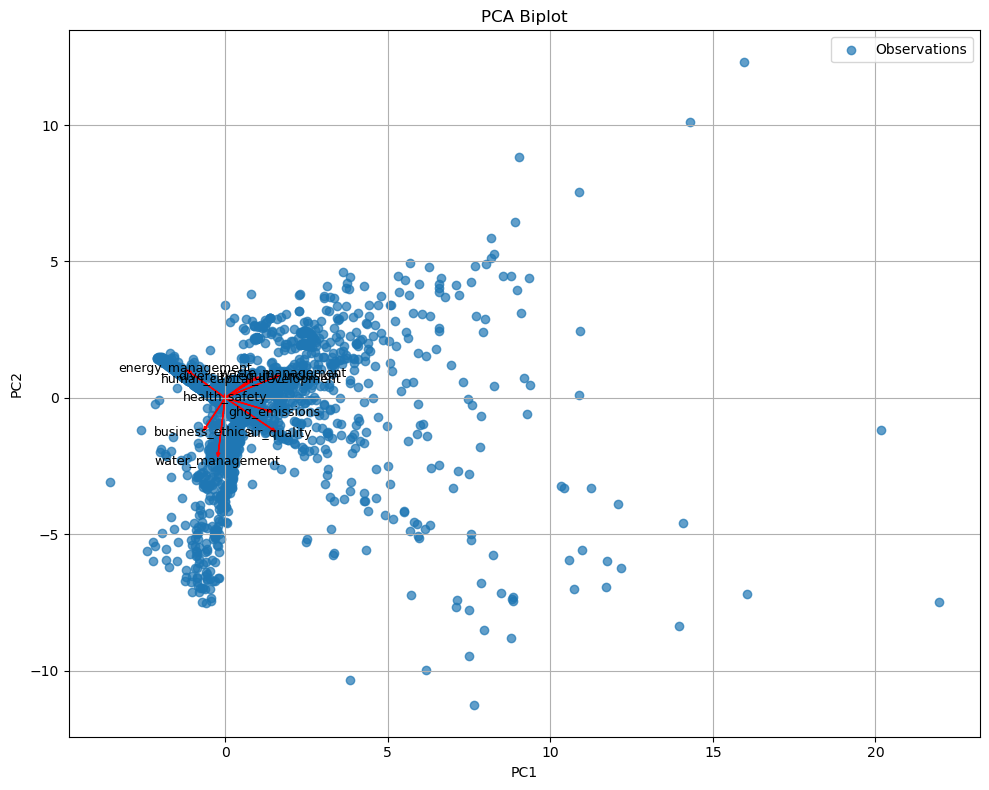

<Figure size 1000x800 with 0 Axes>

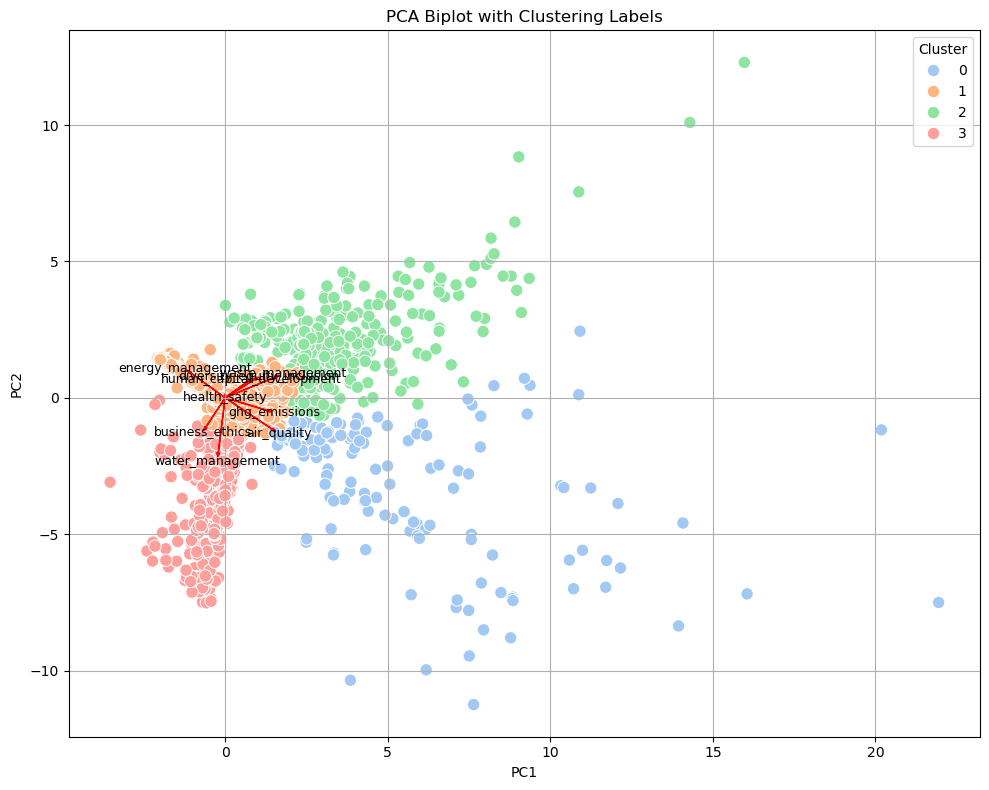

In [32]:

# Create a PCA biplot for PC1 and PC2
plt.figure(figsize=(10, 8))

# Plot the PCA scores (observations)
plt.scatter(pca_scores["PC1"], pca_scores["PC2"], alpha=0.7, label="Observations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")

# Scale factor for arrows (to make the vectors visible in the score space)
# You might need to adjust this scaling factor depending on your data.
arrow_scale = 3

# Plot the loadings as arrows
for i, metric in enumerate(loadings.index):
    
    # Get the loadings for PC1 and PC2
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    
    # Plot an arrow for each metric
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    
    # Annotate the arrow with the metric name
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plot the PCA biplot with clustering labels overlayed
plt.figure(figsize=(10, 8))


clustering = AgglomerativeClustering(n_clusters=4)
pca_scores["cluster"] = clustering.fit_predict(pca_scores[["PC1", "PC2"]])

# Plot the PCA biplot with clustering labels overlayed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_scores, palette="pastel", s=80)

# Define an arrow scale factor (adjust as needed)
arrow_scale = 3

# Plot the loadings as arrows
for metric in loadings.index:
    pc1_loading = loadings.loc[metric, "PC1"]
    pc2_loading = loadings.loc[metric, "PC2"]
    plt.arrow(0, 0,
              pc1_loading * arrow_scale,
              pc2_loading * arrow_scale,
              color='red', width=0.005, head_width=0.1)
    plt.text(pc1_loading * arrow_scale * 1.15,
             pc2_loading * arrow_scale * 1.15,
             metric, color='black', ha='center', va='center', fontsize=9)

plt.title("PCA Biplot with Clustering Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:

# Identify which columns are the PC loadings
pc_cols = [col for col in loadings_with_pillar.columns if col.startswith("PC")]

# Melt the loadings DataFrame so that each row contains one metric’s loading for a given PC
df_melted = loadings_with_pillar.melt(
    id_vars=["metric", "pillar"],      # Keep these columns fixed
    value_vars=pc_cols,                # Unpivot the PC columns
    var_name="PC",                     # New column indicating which PC
    value_name="loading"               # New column with the loading value
)

# Create a column for the absolute loading for ranking purposes
df_melted["abs_loading"] = df_melted["loading"].abs()

# For each PC, select the top N metrics by absolute loading
top_n = 10
top_metrics = df_melted.groupby("PC", group_keys=False).apply(lambda g: g.nlargest(top_n, "abs_loading")).reset_index(drop=True)

top_metrics = top_metrics[["PC", "metric", "pillar", "abs_loading"]]

print("Top metrics driving each PC:")
print(top_metrics)
# Sort the results by PC, then by pillar (alphabetically), then by absolute loading (descending)
top_metrics = top_metrics.sort_values(by=["PC", "pillar", "abs_loading"], ascending=[True, True, False])

print("Top metrics driving each PC:")
print(top_metrics)


Top metrics driving each PC:
     PC                      metric         pillar  abs_loading
0   PC1            waste_management         e_risk     0.514186
1   PC1            waste_management  e_opportunity     0.514186
2   PC1                 air_quality  g_opportunity     0.480429
3   PC1                 air_quality         e_risk     0.480429
4   PC1               ghg_emissions         e_risk     0.435068
5   PC1               ghg_emissions  e_opportunity     0.435068
6   PC1           energy_management  e_opportunity     0.356915
7   PC1  diversity_equity_inclusion  s_opportunity     0.303508
8   PC1  diversity_equity_inclusion         s_risk     0.303508
9   PC1   human_capital_development         s_risk     0.228474
10  PC2            water_management         e_risk     0.673262
11  PC2            water_management  e_opportunity     0.673262
12  PC2                 air_quality  g_opportunity     0.382385
13  PC2                 air_quality         e_risk     0.382385
14  PC2    

In [ ]:
metric_to_pillar_map = {
    "air_quality": "Environmental",
    "business_ethics": "Governance",
    "diversity_equity_inclusion": "Social",
    "energy_management": "Environmental",
    "ghg_emissions": "Environmental",
    "health_safety": "Social",
    "human_capital_development": "Social",
    "waste_management": "Environmental",
    "water_management": "Environmental"
}

loadings["Pillar"] = metric_to_pillar_map  # dictionary mapping metric → pillar

Pillar
Environmental    0.816821
Governance       0.038862
Social           0.144317
Name: PC1, dtype: float64


In [28]:
# For PC1
pillar_contrib_pc1 = loadings.groupby("Pillar")["PC1"].apply(lambda x: (x**2).sum())
pillar_contrib_pc1 = pillar_contrib_pc1 / (loadings["PC1"]**2).sum()  # Normalize

print(pillar_contrib_pc1)

# For PC1
pillar_contrib_pc2 = loadings.groupby("Pillar")["PC2"].apply(lambda x: (x**2).sum())
pillar_contrib_pc2 = pillar_contrib_pc2/ (loadings["PC2"]**2).sum()  # Normalize

print(pillar_contrib_pc2)

# For PC1
pillar_contrib_pc3 = loadings.groupby("Pillar")["PC3"].apply(lambda x: (x**2).sum())
pillar_contrib_pc3 = pillar_contrib_pc3 / (loadings["PC3"]**2).sum()  # Normalize

print(pillar_contrib_pc3)

# For PC1
pillar_contrib_pc4 = loadings.groupby("Pillar")["PC4"].apply(lambda x: (x**2).sum())
pillar_contrib_pc4 = pillar_contrib_pc4 / (loadings["PC4"]**2).sum()  # Normalize

print(pillar_contrib_pc4)

Pillar
Environmental    0.816821
Governance       0.038862
Social           0.144317
Name: PC1, dtype: float64
Pillar
Environmental    0.782795
Governance       0.127772
Social           0.089434
Name: PC2, dtype: float64
Pillar
Environmental    0.775212
Governance       0.114069
Social           0.110720
Name: PC3, dtype: float64
Pillar
Environmental    0.097934
Governance       0.236650
Social           0.665416
Name: PC4, dtype: float64


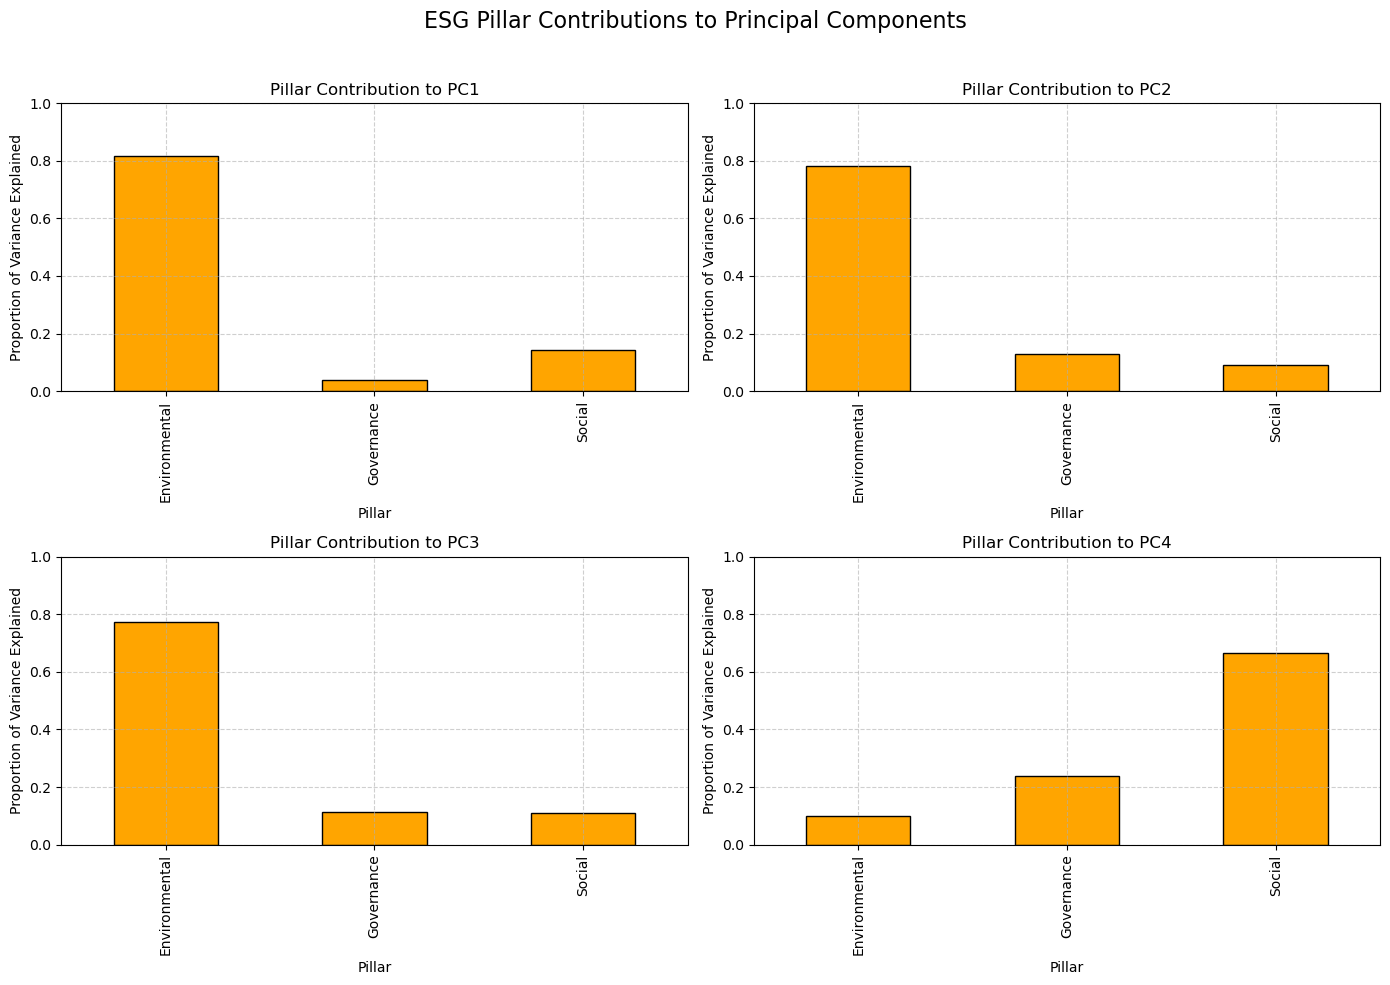

In [29]:
pillar_contrib = {}
for pc in ["PC1", "PC2", "PC3", "PC4"]:
    contrib = loadings.groupby("Pillar")[pc].apply(lambda x: (x**2).sum())
    contrib /= (loadings[pc]**2).sum()  # Normalize to sum to 1
    pillar_contrib[pc] = contrib

pillar_contrib_df = pd.DataFrame(pillar_contrib).fillna(0)  # Fill missing pillars if any

# ---- Step 5: Plot results ----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, pc in enumerate(pillar_contrib_df.columns):
    ax = axes[i]
    pillar_contrib_df[pc].plot(kind='bar', ax=ax, color='orange', edgecolor='black')
    ax.set_title(f'Pillar Contribution to {pc}')
    ax.set_ylabel('Proportion of Variance Explained')
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("ESG Pillar Contributions to Principal Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

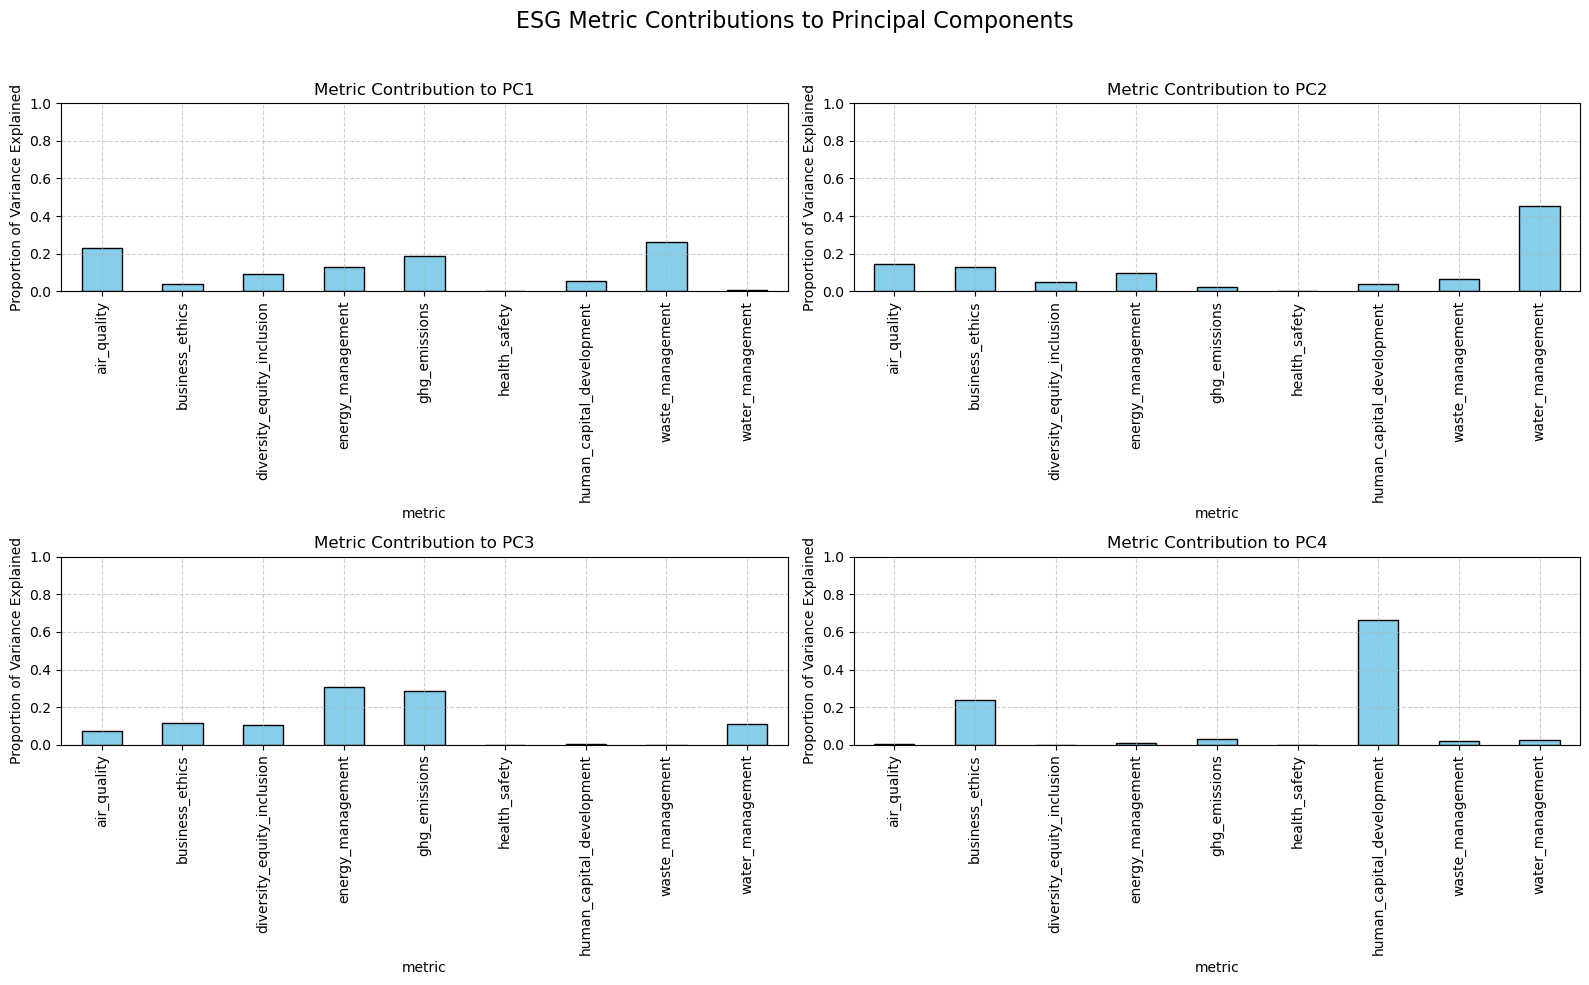

In [31]:
metric_contrib = {}
for pc in ["PC1", "PC2", "PC3", "PC4"]:
    squared = loadings[pc] ** 2
    metric_contrib[pc] = squared / squared.sum()

metric_contrib_df = pd.DataFrame(metric_contrib)

# ---- Step 3: Plot contribution of each metric to each PC ----
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, pc in enumerate(metric_contrib_df.columns):
    ax = axes[i]
    metric_contrib_df[pc].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Metric Contribution to {pc}')
    ax.set_ylabel('Proportion of Variance Explained')
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("ESG Metric Contributions to Principal Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()